# Setting up the GDrive Path

In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
os.chdir('/content/gdrive/My Drive/Alakananda/Customer Analytics')

In [0]:
os.getcwd()

'/content/gdrive/My Drive/Alakananda/Customer Analytics'

In [0]:
!ls

 algo_i_i.sav					  LF_RGSbest.sav
 algo_LF.sav					  mixed_users.csv
 algo_u_u.sav					  only_fiction_users.csv
'Books Recommendation System- Alakananda.ipynb'   ratings.csv
 Final_book_with_Franchise.csv			  to_read_clean.csv
 item_item_RGSbest.sav				  user_user_RGSbest.sav


# Import libraries

In [0]:
!pip install scikit-surprise

In [0]:
import numpy as np
import pandas as pd
import pickle

In [0]:
import surprise
from surprise import SVD, SVDpp, SlopeOne, KNNWithMeans
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, RandomizedSearchCV
from surprise import accuracy

# Function to Calculate precision and Top n recommendations

In [0]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [0]:
from collections import defaultdict
# userid, bookid, true rating, estimated rating. Sorts the matrix by descending order of estimated ratings. Cuts off the top k (10) rows. Within those 10 rows, 
# it calculates the count of books truly liked aka relevant items (true rating >= 4), count of books predicted as liked aka recommended items (est >= 4), 
# and count of books both liked and recommended (est & true rating >=4)

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

#Load Files

In [0]:
#only two files are needed
df = pd.read_csv('ratings.csv')
books = pd.read_csv('Final_book_with_Franchise.csv')
to_read = pd.read_csv('to_read_clean.csv')

# EDA and wrangling

In [0]:
df.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [0]:
#Number of ratings, number of unique users and number of unique books

print(len(df), df['user_id'].nunique(),df['book_id'].nunique())

5976479 53424 10000


In [0]:
#sparcity

len(df)/(df['user_id'].nunique()*df['book_id'].nunique())

0.011186880428271938

In [0]:
books.head()

,book_id,best_book_id,books_count,isbn,authors,original_publication_year,original_title,title,language_code,average_rating,...,other_count,rank_pronoun_1,rank_pronoun_2,rank_person1,rank_person_count1,rank_person2,rank_person_count2,rank_person3,rank_person_count3,franchise
0,1,2767052,272,439023483,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,...,1.0,female,other,katniss,1.0,peeta,0.0,NaN,0.0,The Hunger Games
1,2,3,491,439554934,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,...,2.0,male,other,harry,1.0,hogwarts school,0.0,potter,0.0,Harry Potter
2,3,41865,226,316015849,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,...,0.0,None,None,edward cullen,1.0,bella swan,0.0,stephenie meyer,0.0,Twilight
3,4,2657,487,61120081,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,...,4.0,other,female,harper lee,1.0,academy,0.0,NaN,0.0,NaN
4,5,4671,1356,743273567,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,...,1.0,other,male,jay gatsby,1.0,scott fitzgerald,0.0,daisy buchanan,0.0,NaN


In [0]:
books[['ratings_count', 'ratings_1', 'ratings_2', 'ratings_3',
       'ratings_4', 'ratings_5']].head(10)

,ratings_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,4780653,66715,127936,560092,1481305,2706317
1,4602479,75504,101676,455024,1156318,3011543
2,3866839,456191,436802,793319,875073,1355439
3,3198671,60427,117415,446835,1001952,1714267
4,2683664,86236,197621,606158,936012,947718
5,2346404,47994,92723,327550,698471,1311871
6,2071616,46023,76784,288649,665635,1119718
7,2044241,109383,185520,455042,661516,709176
8,2001311,77841,145740,458429,716569,680175
9,2035490,54700,86485,284852,609755,1155673


In [0]:
(books['ratings_1']+books['ratings_2']+books['ratings_3']+books['ratings_4']+books['ratings_5']).head()

0    4942365
1    4800065
2    3916824
3    3340896
4    2773745
dtype: int64

In [0]:
books[['author_first','authors','publisher']].head(10)

,author_first,authors,publisher
0,suzanne collins,Suzanne Collins,scholastic press
1,j.k. rowling,"J.K. Rowling, Mary GrandPré",scholastic inc
2,stephenie meyer,Stephenie Meyer,"little, brown and company"
3,harper lee,Harper Lee,harper perennial modern classics
4,f. scott fitzgerald,F. Scott Fitzgerald,NaN
5,john green,John Green,dutton books
6,j.r.r. tolkien,J.R.R. Tolkien,houghton mifflin
7,j.d. salinger,J.D. Salinger,back bay books
8,dan brown,Dan Brown,pocket books
9,jane austen,Jane Austen,modern library


In [0]:
books[['original_title','num_pages','Parent_tag','Daughter_tag','description']].head()

,original_title,num_pages,Parent_tag,Daughter_tag,description
0,The Hunger Games,374.0,fiction,fantasy,<b>Winning will make you famous. <br />Losing ...
1,Harry Potter and the Philosopher's Stone,320.0,fiction,fantasy,Harry Potter's life is miserable. His parents ...
2,Twilight,498.0,fiction,fantasy,<b>About three things I was absolutely positiv...
3,To Kill a Mockingbird,324.0,fiction,literature,The unforgettable novel of a childhood in a sl...
4,The Great Gatsby,180.0,fiction,literature,"<b>THE GREAT GATSBY</b>, F. Scott Fitzgerald’s..."


In [0]:
books[['group_count',
       'male_count', 'female_count', 'other_count', 'rank_pronoun_1',
       'rank_pronoun_2', 'rank_person1', 'rank_person_count1', 'rank_person2',
       'rank_person_count2', 'rank_person3', 'rank_person_count3']].head()

,group_count,male_count,female_count,other_count,rank_pronoun_1,rank_pronoun_2,rank_person1,rank_person_count1,rank_person2,rank_person_count2,rank_person3,rank_person_count3
0,0.0,0.0,2.0,1.0,female,other,katniss,1.0,peeta,0.0,NaN,0.0
1,0.0,12.0,0.0,2.0,male,other,harry,1.0,hogwarts school,0.0,potter,0.0
2,0.0,0.0,0.0,0.0,None,None,edward cullen,1.0,bella swan,0.0,stephenie meyer,0.0
3,0.0,0.0,1.0,4.0,other,female,harper lee,1.0,academy,0.0,NaN,0.0
4,0.0,0.0,0.0,1.0,other,male,jay gatsby,1.0,scott fitzgerald,0.0,daisy buchanan,0.0


In [0]:
books.columns

Index(['book_id', 'best_book_id', 'books_count', 'isbn', 'authors',
       'original_publication_year', 'original_title', 'title', 'language_code',
       'average_rating', 'ratings_count', 'work_ratings_count',
       'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3',
       'ratings_4', 'ratings_5', 'author_first', 'num_pages', 'publisher',
       'Parent_tag', 'Daughter_tag', 'description', 'group_count',
       'male_count', 'female_count', 'other_count', 'rank_pronoun_1',
       'rank_pronoun_2', 'rank_person1', 'rank_person_count1', 'rank_person2',
       'rank_person_count2', 'rank_person3', 'rank_person_count3',
       'franchise'],
      dtype='object')

In [0]:
books.drop(columns=['best_book_id', 'books_count', 'isbn','authors', 'work_ratings_count',
       'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3',
       'ratings_4', 'ratings_5', 'description', 'group_count',
       'male_count', 'female_count', 'other_count','rank_person_count1','rank_person_count2', 'rank_person3','rank_person_count3'],inplace = True)

In [0]:
books.head()

,book_id,original_publication_year,original_title,title,language_code,average_rating,ratings_count,author_first,num_pages,publisher,Parent_tag,Daughter_tag,rank_pronoun_1,rank_pronoun_2,rank_person1,rank_person2,franchise
0,1,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,suzanne collins,374.0,scholastic press,fiction,fantasy,female,other,katniss,peeta,The Hunger Games
1,2,1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,j.k. rowling,320.0,scholastic inc,fiction,fantasy,male,other,harry,hogwarts school,Harry Potter
2,3,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,stephenie meyer,498.0,"little, brown and company",fiction,fantasy,None,None,edward cullen,bella swan,Twilight
3,4,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,harper lee,324.0,harper perennial modern classics,fiction,literature,other,female,harper lee,academy,NaN
4,5,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,f. scott fitzgerald,180.0,NaN,fiction,literature,other,male,jay gatsby,scott fitzgerald,NaN


In [0]:
books.loc[books['original_title'].isnull(),'original_title'] = books.loc[books['original_title'].isnull(),'title'] 

In [0]:
books[books['original_title'].isnull()]

,book_id,original_publication_year,original_title,title,language_code,average_rating,ratings_count,author_first,num_pages,publisher,Parent_tag,Daughter_tag,rank_pronoun_1,rank_pronoun_2,rank_person1,rank_person2,franchise


In [0]:
leadgendermissing = books.loc[(books['rank_pronoun_1']=='None')|(books['rank_pronoun_1']=='other'),['original_title','author_first','rank_person1','rank_person2']]

In [0]:
leadgendermissing.to_csv('MissingLeadGender.csv',index=False)

In [0]:
titles = books[['title','book_id']]

In [0]:
df = pd.merge(df,titles,on='book_id')
df.head()

,user_id,book_id,rating,title
0,1,258,5,The Shadow of the Wind (The Cemetery of Forgot...
1,11,258,3,The Shadow of the Wind (The Cemetery of Forgot...
2,143,258,4,The Shadow of the Wind (The Cemetery of Forgot...
3,242,258,5,The Shadow of the Wind (The Cemetery of Forgot...
4,325,258,4,The Shadow of the Wind (The Cemetery of Forgot...


In [0]:
df.shape

(5976479, 4)

# Data Exploration for finding out the most read and best rated books 

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 

Let's create a ratings dataframe with average rating and number of ratings:

In [0]:
# Find out the books with high average ratings 
df.groupby('title')['rating'].mean().sort_values(ascending = False).head()

title
The Complete Calvin and Hobbes                             4.829876
ESV Study Bible                                            4.818182
Attack of the Deranged Mutant Killer Monster Snow Goons    4.768707
The Indispensable Calvin and Hobbes                        4.766355
The Revenge of the Baby-Sat                                4.761364
Name: rating, dtype: float64

In [0]:
# Find out the books which are most watched 
df.groupby('title')['rating'].count().sort_values(ascending = False).head()

title
The Hunger Games (The Hunger Games, #1)                     22806
Harry Potter and the Sorcerer's Stone (Harry Potter, #1)    21850
To Kill a Mockingbird                                       19088
Twilight (Twilight, #1)                                     16931
The Great Gatsby                                            16604
Name: rating, dtype: int64

In [0]:
ratinginfo = pd.DataFrame(df.groupby('title')['rating'].mean())
ratinginfo.head()

,rating
title,
"Angels (Walsh Family, #3)",3.562738
"""حكايات فرغلي المستكاوي ""حكايتى مع كفر السحلاوية",3.407080
#GIRLBOSS,3.476923
'Salem's Lot,3.938868
"'Tis (Frank McCourt, #2)",3.570413


In [0]:
# Adding a new column with number of times a book has been rated 
ratinginfo['num_rating'] = pd.DataFrame(df.groupby('title')['rating'].count())

In [0]:
ratinginfo.head()

,rating,num_rating
title,,
"Angels (Walsh Family, #3)",3.562738,263
"""حكايات فرغلي المستكاوي ""حكايتى مع كفر السحلاوية",3.407080,113
#GIRLBOSS,3.476923,195
'Salem's Lot,3.938868,4433
"'Tis (Frank McCourt, #2)",3.570413,703


In [0]:
ratinginfo.sort_values('num_rating',ascending=False).head(5)
#made the title as the index of the dataframe

,rating,num_rating
title,,
"The Hunger Games (The Hunger Games, #1)",4.279707,22806
"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",4.351350,21850
To Kill a Mockingbird,4.329369,19088
"Twilight (Twilight, #1)",3.214341,16931
The Great Gatsby,3.772224,16604


In [0]:
#above EDA acutally already existed in book.csv

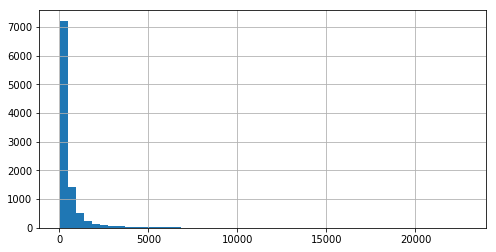

In [0]:
#Analysing the distribution of "how often books are rated - most books are watched _ times or under"
plt.figure(figsize=(8,4))
ratinginfo['num_rating'].hist(bins=50)

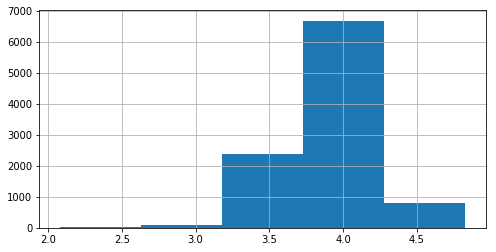

In [0]:
#most ratings are between 3.5 and 4.5 stars
plt.figure(figsize=(8,4))
ratinginfo['rating'].hist(bins=5)

C:\Users\SBM\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\SBM\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\SBM\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


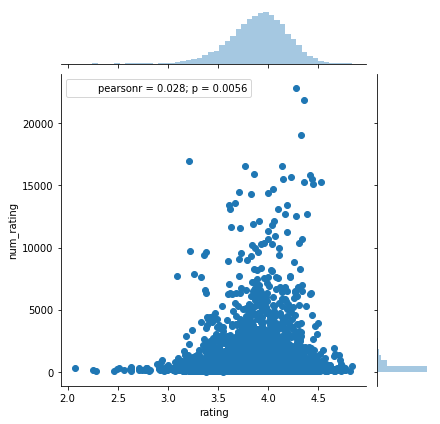

In [0]:
#books watched more times are generally rated 3 and above and hence are popular 
sns.jointplot(x='rating',y='num_rating',data=ratinginfo)
#you will look for higher rating book to watch and more people watching more people giving higher rating

# Data Reduction - Taking only 75th percentile of users and 50th percentile books (truncated, 1.7 mil data)

In [0]:
reviews_per_book = df.groupby('book_id').book_id.apply( lambda x: len( x ))
reviews_per_book.describe()

count    10000.000000
mean       597.647900
std       1267.289788
min          8.000000
25%        155.000000
50%        248.000000
75%        503.000000
max      22806.000000
Name: book_id, dtype: float64

In [0]:
reviews_per_book_median = df.groupby( 'book_id' ).book_id.apply( lambda x: len( x )).median()
reviews_per_book_median

248.0

In [0]:
reviews_per_user = df.groupby('user_id').user_id.apply( lambda x: len( x ))
reviews_per_user.describe()

count    53424.000000
mean       111.868804
std         26.071224
min         19.000000
25%         96.000000
50%        111.000000
75%        128.000000
max        200.000000
Name: user_id, dtype: float64

In [0]:
reviews_per_user_median = df.groupby( 'user_id' ).user_id.apply( lambda x: len( x )).median()
reviews_per_user_median
reviews_per_user_75thPct = 128

In [0]:
filter_books = df['title'].value_counts() > reviews_per_book_median
filter_books = filter_books[filter_books].index.tolist()

filter_users =df['user_id'].value_counts() > reviews_per_user_75thPct
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['title'].isin(filter_books)) & (df['user_id'].isin(filter_users))]
#df_new = df[(df['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(5976479, 4)
The new data frame shape:	(1709263, 4)


In [0]:
filter_bookids = df['book_id'].value_counts() > reviews_per_book_median
filter_bookids = filter_bookids[filter_bookids].index.tolist()

In [0]:
df_new.book_id.nunique(),df_new.user_id.nunique()

(5009, 12952)

In [0]:
np.sqrt(df_new.book_id.nunique()), np.sqrt(df_new.user_id.nunique())

(70.77428911688199, 113.80685392365436)

In [0]:
#download surprise module using conda: conda install -c conda-forge scikit-surprise

# Creating dataset object for collaborative filtering (truncated, 1.7 mil)

In [0]:
#change the df_new here to df to skip the filtering earlier
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_new[['user_id', 'title', 'rating']], reader)

# Parameter tuning for collaborative algorithms by doing cv across the 1.7 mil data
  1. best item-item model- RMSE: 0.8133962262091288; Parameters: {'k': 80, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}

  2. best user-user model- RMSE: 0.8265788845649183; Parameters: {'k': 100, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}

  3. best LF model- RMSE: 0.8303826655531948; Parameters: {'n_factors': 50, 'reg_all': 0.04}

## User-User Similarity

In [0]:
param_grid = {'k': [20,40,50,60,80,100],
             'sim_options': {'name': ['pearson_baseline','cosine'], 'user_based': [True]}
             }

rgs = RandomizedSearchCV(KNNWithMeans, param_grid,n_iter=5, measures=['rmse'], cv=3)

rgs.fit(data)

# best RMSE score
print(rgs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(rgs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...

In [0]:
param_grid = {'k': [200,300],
             'sim_options': {'name': ['pearson_baseline'], 'user_based': [True]}
             }

rgs = RandomizedSearchCV(KNNWithMeans, param_grid,n_iter=2, measures=['rmse'], cv=3)

rgs.fit(data)

# best RMSE score
print(rgs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(rgs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
0.8285620426454064
{'k': 200, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}


In [0]:
#best user-user model
#0.8265788845649183
#{'k': 100, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}

algo_u_u = rgs.best_estimator['rmse']

In [0]:
#pickle save
pickle.dump(algo_u_u,open('user_user_RGSbest.sav','wb'))

## Item-Item Similarity

In [0]:
param_grid = {'k': [50,60,80,100,200],
             'sim_options': {'name': ['pearson_baseline','cosine'], 'user_based': [False]}
             }

rgs = RandomizedSearchCV(KNNWithMeans, param_grid,n_iter=5, measures=['rmse'], cv=3)

rgs.fit(data)

# best RMSE score
print(rgs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(rgs.best_params['rmse'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similari

In [0]:
#best item-item model
#0.8133962262091288
#{'k': 80, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}
algo_i_i = rgs.best_estimator['rmse']

In [0]:
#pickle save
pickle.dump(algo_i_i,open('item_item_RGSbest.sav','wb'))

## Latent Factorisation

In [0]:
param_grid = {'n_factors': [10,20,30,40,50],
              #'lr_all': [0.002,0.005,0.007,0.01],
              'reg_all': [0.01,0.02,0.03,0.04,0.05]
             }

rgs = RandomizedSearchCV(SVDpp, param_grid,n_iter=5, measures=['rmse'], cv=3, n_jobs=-2, joblib_verbose=5)

rgs.fit(data)

# best RMSE score
print(rgs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(rgs.best_params['rmse'])

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed: 35.4min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed: 71.0min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   3 out of   3 | elapsed: 106.5min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   4 out of   4 | elapsed: 147.9min remaining:    0.0s


0.8303826655531948
{'n_factors': 50, 'reg_all': 0.04}


[Parallel(n_jobs=-2)]: Done  15 out of  15 | elapsed: 426.4min finished


In [0]:
#best item-item model
#0.8303826655531948
#{'n_factors': 50, 'reg_all': 0.04}
algo_LF = rgs.best_estimator['rmse']

In [0]:
#pickle save
import pickle
pickle.dump(algo_LF,open('LF_RGSbest.sav','wb'))

# Train best model in each algorithm on truncated train dataset (1.7 mil ratings)
  - save trained models algo_i_i, algo_u_u, algo_LF

In [0]:
trainset = data.build_full_trainset()

In [0]:
#pickle load USER-USER
algo_u_u = pickle.load(open('user_user_RGSbest.sav','rb'))

In [0]:
#Fit user-user model
algo_u_u.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
#pickle load ITEM-ITEM
algo_i_i = pickle.load(open('item_item_RGSbest.sav','rb'))

In [0]:
#Fit item-item model
algo_i_i.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
#pickle load Latent Factorisation
algo_LF = pickle.load(open('LF_RGSbest.sav','rb'))

In [0]:
#Fit LF Model
algo_LF.fit(trainset)

In [0]:
pickle.dump(algo_LF,open('algo_LF.sav','wb'))
pickle.dump(algo_u_u,open('algo_u_u.sav','wb'))
pickle.dump(algo_i_i,open('algo_i_i.sav','wb'))

## Load models trained on 1.7 mil data

In [0]:
trainset = data.build_full_trainset()

In [0]:
algo_LF = pickle.load(open('algo_LF.sav','rb'))
algo_u_u = pickle.load(open('algo_u_u.sav','rb'))
algo_i_i = pickle.load(open('algo_i_i.sav','rb'))

# User-wise recommendations - Demo (with models trained on 1.7 mil data)

In [0]:
df_new['user_id'].unique()

array([  143,   325,   362, ...,  2165, 27404, 31327])

In [0]:
i=1
user_input = input("Please enter user_id to recommend for her/him: ")
while (i == 1):
  if (pd.to_numeric(user_input) not in list(df_new['user_id'])):
    print("User_id is not in training set. Enter some other value.")
    user_input = input("Please enter user_id to recommend for her/him: ")
  else:
    i=0

#entered 143

Please enter user_id to recommend for her/him: 143


In [0]:
#here determines whether iid is id or title
#get a list of all book ids
iids = df_new['title'].unique()
#get a list of iids that uid 143 has rated
iids76 = df_new.loc[df['user_id']==user_input,'title']
#remove the iids that uid 76 has rated from the list of all book ids
iids_to_pred = np.setdiff1d(iids,iids76)

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [0]:
iids_to_pred

array([' Angels (Walsh Family, #3)', "'Salem's Lot",
       "'Tis (Frank McCourt, #2)", ..., 'شيكاجو', 'عزازيل', 'يوتوبيا'],
      dtype=object)

In [0]:
#USER-USER
predictions_uu = [algo_u_u.predict(pd.to_numeric(user_input),iid) for iid in iids_to_pred]
predictions_uu[0]
#convert to array to see all

Prediction(uid=143, iid=' Angels (Walsh Family, #3)', r_ui=None, est=3.3326294825958875, details={'actual_k': 41, 'was_impossible': False})

In [0]:
#USER-USER
algo_u_u.predict(143,' Angels (Walsh Family, #3)',5)

Prediction(uid=143, iid=' Angels (Walsh Family, #3)', r_ui=5, est=3.3326294825958875, details={'actual_k': 41, 'was_impossible': False})

In [0]:
#USER-USER
pred_ratings_uu = np.array([pred.est for pred in predictions_uu])
#find the index of the maximum predicted rating
i_max = pred_ratings_uu.argmax()
#use this to find the corresponding iid to recommend
iid = iids_to_pred[i_max]
print('Top book for user {2} is "{0}" with predicted rating of {1}.'.format (iid,pred_ratings_uu[i_max],user_input))

Top book for user 143 is "The Days Are Just Packed: A Calvin and Hobbes Collection" with predicted rating of 4.688712230007349.


In [0]:
#USER_USER
#for top 5 predicted ratings
pred_ratings_uu = np.array([pred.est for pred in predictions_uu])
#find the index of the maximum predicted rating
i_maxs = np.argsort(-1*pred_ratings_uu)[:10]
iids_uu = iids_to_pred[i_maxs]
print('Top books for user {2} are: {0} with predicted rating of {1} respectively.'.format (iids_uu,pred_ratings_uu[i_maxs],user_input))

Top books for user 143 are: ['The Days Are Just Packed: A Calvin and Hobbes Collection'
 'Elon Musk: Inventing the Future'
 'Harry Potter and the Deathly Hallows (Harry Potter, #7)'
 "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)"
 'Harry Potter and the Goblet of Fire (Harry Potter, #4)'
 'The Hunger Games (The Hunger Games, #1)' 'The Help'
 "The Girl Who Kicked the Hornet's Nest (Millennium, #3)"
 'The Girl with the Dragon Tattoo (Millennium, #1)'
 'Harry Potter Boxset (Harry Potter, #1-7)'] with predicted rating of [4.68871223 4.61954837 4.61488632 4.55920874 4.55662382 4.54798635
 4.54788359 4.54095724 4.52660445 4.52434293] respectively.


In [0]:
#ITEM-ITEM
predictions_ii = [algo_i_i.predict(pd.to_numeric(user_input),iid) for iid in iids_to_pred]
predictions_ii[0]
#convert to array to see all

Prediction(uid=143, iid=' Angels (Walsh Family, #3)', r_ui=None, est=3.209526120916456, details={'actual_k': 54, 'was_impossible': False})

In [0]:
#ITEM-ITEM
algo_i_i.predict(143,' Angels (Walsh Family, #3)',5)

Prediction(uid=143, iid=' Angels (Walsh Family, #3)', r_ui=5, est=3.209526120916456, details={'actual_k': 54, 'was_impossible': False})

In [0]:
#ITEM-ITEM
pred_ratings_ii = np.array([pred.est for pred in predictions_ii])
#find the index of the maximum predicted rating
i_max = pred_ratings_ii.argmax()
#use this to find the corresponding iid to recommend
iid = iids_to_pred[i_max]
print('Top book for user {2} is "{0}" with predicted rating of {1}.'.format (iid,pred_ratings_ii[i_max],user_input))

Top book for user 143 is "يوتوبيا" with predicted rating of 5.0.


In [0]:
#ITEM-ITEM
#for top 5 predicted ratings
pred_ratings_ii = np.array([pred.est for pred in predictions_ii])
#find the index of the maximum predicted rating
i_maxs = np.argsort(-1*pred_ratings_ii)[:10]
iids_ii = iids_to_pred[i_maxs]
print('Top books for user {2} are: {0} with predicted rating of {1} respectively.'.format (iids_ii,pred_ratings_ii[i_maxs],user_input))

Top books for user 143 are: ['يوتوبيا' 'Breathe (Colorado Mountain, #4)'
 'Lady Luck (Colorado Mountain, #3)'
 'Mistborn Trilogy Boxed Set (Mistborn, #1-3)' 'The Hobbit: Graphic Novel'
 'A Court of Mist and Fury (A Court of Thorns and Roses, #2)'
 'The Calvin and Hobbes Tenth Anniversary Book' 'The Complete Novels'
 'Elon Musk: Inventing the Future' "The Razor's Edge"] with predicted rating of [5.         4.83599717 4.82017883 4.81092043 4.78029911 4.77803232
 4.76344154 4.75133549 4.72376244 4.70270399] respectively.


In [0]:
df_new['rating'].mean()

3.8771792287085134

In [0]:
#LF
predictions_lf = [algo_LF.predict(pd.to_numeric(user_input),iid) for iid in iids_to_pred]
predictions_lf[0]
#convert to array to see all

Prediction(uid=143, iid=' Angels (Walsh Family, #3)', r_ui=None, est=3.2920648857850554, details={'was_impossible': False})

In [0]:
#LF
algo_LF.predict(143,' Angels (Walsh Family, #3)',5)

Prediction(uid=143, iid=' Angels (Walsh Family, #3)', r_ui=5, est=3.2920648857850554, details={'was_impossible': False})

In [0]:
#LF
pred_ratings_lf = np.array([pred.est for pred in predictions_lf])
#find the index of the maximum predicted rating
i_max = pred_ratings_lf.argmax()
#use this to find the corresponding iid to recommend
iid = iids_to_pred[i_max]
print('Top book for user {2} is "{0}" with predicted rating of {1}.'.format (iid,pred_ratings_lf[i_max],user_input))

Top book for user 143 is "The Days Are Just Packed: A Calvin and Hobbes Collection" with predicted rating of 4.682162115202545.


In [0]:
#LF
#for top 5 predicted ratings
pred_ratings_lf = np.array([pred.est for pred in predictions_lf])
#find the index of the maximum predicted rating
i_maxs = np.argsort(-1*pred_ratings_lf)[:10]
iids_lf = iids_to_pred[i_maxs]
print('Top books for user {2} are: {0} with predicted rating of {1} respectively.'.format (iids_lf,pred_ratings_lf[i_maxs],user_input))

Top books for user 143 are: ['The Days Are Just Packed: A Calvin and Hobbes Collection'
 'Harry Potter Boxset (Harry Potter, #1-7)'
 'Words of Radiance (The Stormlight Archive, #2)'
 'The Complete Calvin and Hobbes'
 'The Calvin and Hobbes Tenth Anniversary Book'
 'The Calvin and Hobbes Lazy Sunday Book' 'Morning Star (Red Rising, #3)'
 'The Complete Novels'
 'Book of Mormon, Doctrine and Covenants, Pearl of Great Price'
 "It's a Magical World: A Calvin and Hobbes Collection"] with predicted rating of [4.68216212 4.65997612 4.61472489 4.60400312 4.59541322 4.56766063
 4.53802029 4.5352031  4.50580438 4.48829474] respectively.


# Calculating Precision - BookMarks dataset based prediction - Failed Attempt

  - In this approach, Bookmarks dataset is assumed to be a list of all books that a user likes. But bookmarks actually aren't indicative of whether the user liked the book or not, rather it is just a list of books he wishes to read, but may or may not like it in the end.

  - The precision function expects a dataset where true ratings as well as estimated ratings range between 1-5. It filters out only estimated ratings which are >=4 for n_recommended, and (est & true >=4) for books recommended as well as liked. In bookmarks, all books are assumed to be liked (true = 5),but the n_recommended becomes 0 many a times, if est < 4. This leads to malfunction of the precision function (DIV 0/0 error, when dividing [[liked + recommended]/recommended]). This happens mainly because bookmarked books need not necessarily be liked by the user, and so, the fundamental assumption is wrong.

In [0]:
to_read.drop(columns='Unnamed: 0',inplace = True)

In [0]:
to_read.head()

,user_id,future_read,title,Rating
0,9,8,The Catcher in the Rye,5
1,15,398,Fast Food Nation: The Dark Side of the All-Ame...,5
2,15,275,An Abundance of Katherines,5
3,37,7173,Musashi,5
4,34,380,Norwegian Wood,5


In [0]:
print(to_read.shape, to_read['user_id'].nunique(), to_read['future_read'].nunique())

(912275, 4) 48866 9986


In [0]:
to_read_subset = to_read[(to_read['user_id'].isin(filter_users)) & (to_read['future_read'].isin(filter_bookids))]
print("Old Shape: ", to_read.shape)
print("New Shape: ", to_read_subset.shape)

Old Shape:  (912275, 4)
New Shape:  (136694, 4)


In [0]:
print(to_read_subset.shape, to_read_subset['user_id'].nunique(), to_read_subset['future_read'].nunique())

(136694, 4) 11348 4825


In [0]:
to_read_subset.dtypes

user_id         int64
future_read     int64
title          object
Rating          int64
dtype: object

In [0]:
to_read_subset.groupby('user_id').agg({'future_read':'count'}).describe()

,future_read
count,11348.000000
mean,12.045647
std,10.238998
min,1.000000
25%,4.000000
50%,9.000000
75%,17.000000
max,67.000000


In [0]:
NumberOfBookMarks = to_read_subset.groupby('user_id').agg({'future_read':'count'})

In [0]:
NumberOfBookMarks

,future_read
user_id,
7,8
9,22
35,2
36,14
40,3
...,...
53381,10
53403,13
53409,15


In [0]:
pd.Series(NumberOfBookMarks['future_read']>=5).value_counts()

True     8186
False    3162
Name: future_read, dtype: int64

In [0]:
to_read_subset5 = to_read_subset[to_read_subset['user_id'].isin(NumberOfBookMarks[NumberOfBookMarks['future_read']>=5].index)]

In [0]:
#change the df_new here to df to skip the filtering earlier
reader = Reader(rating_scale=(1, 5))
data_bookmark = Dataset.load_from_df(to_read_subset5[['user_id', 'title', 'Rating']], reader)
testset_bm = data_bookmark.build_full_trainset()
testset = testset_bm.build_testset()

In [0]:
predictions_uu_test = algo_u_u.test(testset)
precisions, recalls = precision_recall_at_k(predictions_uu_test, k=5, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

1.0
0.2510974842384956


In [0]:
predictions_ii_test = algo_i_i.test(testset)
precisions, recalls = precision_recall_at_k(predictions_ii_test, k=5, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

1.0
0.2634295197778006


In [0]:
predictions_LF_test = algo_LF.test(testset)
precisions, recalls = precision_recall_at_k(predictions_LF_test, k=5, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

1.0
0.2558973544511971


In [0]:
to_read_subset_exactly5 = to_read_subset[to_read_subset['user_id'].isin(NumberOfBookMarks[NumberOfBookMarks['future_read']==5].index)]

In [0]:
#change the df_new here to df to skip the filtering earlier
reader = Reader(rating_scale=(1, 5))
data_bookmark_5 = Dataset.load_from_df(to_read_subset_exactly5[['user_id', 'title', 'Rating']], reader)
testset_bm_5 = data_bookmark_5.build_full_trainset()
testset_5 = testset_bm_5.build_testset()

In [0]:
predictions_uu_test = algo_u_u.test(testset_5)
precisions, recalls = precision_recall_at_k(predictions_uu_test, k=5, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

1.0
0.4350168350168351


In [0]:
predictions_ii_test = algo_i_i.test(testset_5)
precisions, recalls = precision_recall_at_k(predictions_ii_test, k=5, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

1.0
0.43636363636363645


In [0]:
predictions_LF_test = algo_LF.test(testset_5)
precisions, recalls = precision_recall_at_k(predictions_LF_test, k=5, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

1.0
0.4202020202020202


## Anti-split of training data

In [0]:
testset = trainset.build_anti_testset()

In [0]:
# Then predict ratings for all pairs (u, i) that are NOT in the training set.

predictions_uu = algo_u_u.test(testset)

top_n_uu = get_top_n(predictions_uu, n=10)

In [0]:
# Convert dict to df

Top10Recommendations_uu = pd.DataFrame.from_dict(top_n_uu)

# Calculating Precision on a 50% sample of the anti-set (remaining 4 million ratings) by applying models trained on 1.7 mil data - Failed Attempt
  - This is because, this dataset had users and items that were not in the train set

In [0]:
df_antiset = df.merge(df_new.drop_duplicates(), on=['user_id','book_id'], 
                   how='left', indicator=True)
df_antiset = df_antiset[df_antiset['_merge'] == 'left_only']
df_antiset.drop(columns=['rating_y','title_y','_merge'],inplace=True)
df_antiset.rename(columns={"rating_x": "rating", "title_x": "title"},inplace = True)
df_antiset

,user_id,book_id,rating,title
0,1,258,5,The Shadow of the Wind (The Cemetery of Forgot...
1,11,258,3,The Shadow of the Wind (The Cemetery of Forgot...
3,242,258,5,The Shadow of the Wind (The Cemetery of Forgot...
9,473,258,4,The Shadow of the Wind (The Cemetery of Forgot...
11,579,258,5,The Shadow of the Wind (The Cemetery of Forgot...
...,...,...,...,...
5976474,36773,9548,5,"Vicious (Sinners of Saint, #1)"
5976475,50673,9548,4,"Vicious (Sinners of Saint, #1)"
5976476,45213,9548,3,"Vicious (Sinners of Saint, #1)"
5976477,12872,9548,4,"Vicious (Sinners of Saint, #1)"


In [0]:
df_antiset['book_id'].isin(df_new['book_id']).value_counts()

True     3476168
False     791048
Name: book_id, dtype: int64

In [0]:
df_antiset['user_id'].isin(df_new['user_id']).value_counts()

False    4088640
True      178576
Name: user_id, dtype: int64

In [0]:
df_antiset_sub = df_antiset[df_antiset['user_id'].isin(df_new['user_id'])]

In [0]:
df_antiset_sub = df_antiset_sub[df_antiset_sub['book_id'].isin(df_new['book_id'])]

In [0]:
print(df_antiset.shape,df_antiset_sub.shape)

(4267216, 4) (0, 4)


In [0]:
df_new.loc[df_new['book_id']==258,:]

,user_id,book_id,rating,title
2,143,258,4,The Shadow of the Wind (The Cemetery of Forgot...
4,325,258,4,The Shadow of the Wind (The Cemetery of Forgot...
5,362,258,2,The Shadow of the Wind (The Cemetery of Forgot...
6,389,258,2,The Shadow of the Wind (The Cemetery of Forgot...
7,396,258,3,The Shadow of the Wind (The Cemetery of Forgot...
...,...,...,...,...
3514,12383,258,5,The Shadow of the Wind (The Cemetery of Forgot...
3522,11174,258,2,The Shadow of the Wind (The Cemetery of Forgot...
3523,27181,258,2,The Shadow of the Wind (The Cemetery of Forgot...
3524,10157,258,4,The Shadow of the Wind (The Cemetery of Forgot...


## Failed attempt - users/books in this dataset were not in train dataset

In [0]:
filter_users_antiset = df_antiset['user_id'].value_counts() >= 100
filter_users_antiset = filter_users_antiset[filter_users_antiset].index.tolist()

df_antiset_sub = df_antiset[(df_antiset['user_id'].isin(filter_users_antiset))]
#df_new = df[(df['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df_antiset.shape))
print('The new data frame shape:\t{}'.format(df_antiset_sub.shape))

The original data frame shape:	(4267216, 4)
The new data frame shape:	(2727798, 4)


In [0]:
#change the df_new here to df to skip the filtering earlier
reader = Reader(rating_scale=(1, 5))
data_antiset = Dataset.load_from_df(df_antiset_sub[['user_id', 'title', 'rating']], reader)
data_antiset, testset = train_test_split(data_antiset, test_size=0.99)

In [0]:
len(testset)

2700521

In [0]:
predictions_uu_test = algo_u_u.test(testset)
precisions, recalls = precision_recall_at_k(predictions_uu_test, k=100, threshold=5)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

1.0
0.012721697331344274


In [0]:
predictions_ii_test = algo_i_i.test(testset)
precisions, recalls = precision_recall_at_k(predictions_ii_test, k=100, threshold=5)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

1.0
0.012721697331344274


In [0]:
predictions_LF_test = algo_LF.test(testset)
precisions, recalls = precision_recall_at_k(predictions_LF_test, k=100, threshold=5)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

1.0
0.012721697331344274


# Re-train best model (algo_i_i) on a 70% subset of 4-million ratings dataset and check precision on remaining 30%
  - Precision = 88.2%

In [0]:
print('The original data frame shape:\t{}'.format(df_antiset.shape))

The original data frame shape:	(4267216, 4)


In [0]:
#change the df_new here to df to skip the filtering earlier
reader = Reader(rating_scale=(1, 5))
data_antiset = Dataset.load_from_df(df_antiset[['user_id', 'title', 'rating']], reader)
train_antiset, testset = train_test_split(data_antiset, test_size=0.30)

In [0]:
len(testset)

1280165

In [0]:
algo_i_i.fit(train_antiset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
predictions_ii_test_antiset = algo_i_i.test(testset)
precisions, recalls = precision_recall_at_k(predictions_ii_test_antiset, k=10, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.8816591481714723
0.37520278416451136


# Re-train best model (algo_i_i) on a 75% subset of 1.7-million ratings dataset and check precision on remaining 25% 
  - Precision = 89.98%

In [0]:
trainset75, testset = train_test_split(data, test_size=0.25)

In [0]:
algo_i_i.fit(trainset75)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
predictions_ii_test20 = algo_i_i.test(testset)
precisions, recalls = precision_recall_at_k(predictions_ii_test20, k=10, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.8998331446022506
0.2863963556171788


# Re-train best model (algo_i_i) on a 55% subset of entire 5.9-million ratings dataset and check precision on remaining 45% 
  - Save model as algo_i_i_whole
  - Precision = 89.41%

In [0]:
algo_i_i_whole = pickle.load(open('algo_i_i.sav','rb'))

In [0]:
#change the df_new here to df to skip the filtering earlier
reader = Reader(rating_scale=(1, 5))
data_whole = Dataset.load_from_df(df[['user_id', 'title', 'rating']], reader)

In [0]:
trainset_55, testset_45 = train_test_split(data_whole, test_size=0.45)

In [0]:
algo_i_i_whole.fit(trainset_55)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
pickle.dump(algo_i_i_whole,open('algo_i_i_whole.sav','wb'))

In [0]:
predictions_ii_test_45 = algo_i_i_whole.test(testset_45)
precisions, recalls = precision_recall_at_k(predictions_ii_test_45, k=10, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.8941073315247051
0.22235879493349242


# Item-Item similarity on segmented dataset 
   - Re-train best model (algo_i_i) on subsets of two separate datasets - users_fiction ratings and users_mixed ratings. Save models as algo_i_i_fic and algo_i_i_mix. Check precision of these models on the remaining test subsets.  
  - Precision on pure fiction user ratings = 81.77%
  - Precision on user_mixed ratings = 89.51%

Segmented approach didn't work because the dataset wasn't rich enough for pure fiction. Out of 5.9mil ratings, 5.7 mil ratings belonged to users who preferred mixed category, and 0.2 mil ratings belonged to users who preferred pure fiction


In [0]:
users_mixed_genre = pd.read_csv('mixed_users.csv')
users_fiction = pd.read_csv('only_fiction_users.csv')

In [0]:
df.shape, users_mixed_genre.shape, users_fiction.shape

((5976479, 4), (5709336, 6), (267143, 6))

In [0]:
users_mixed_genre = pd.merge(users_mixed_genre,titles,on='book_id')
users_mixed_genre.head()

,user_id,book_id,rating,Parent_tag,Daughter_tag,title
0,1,258,5,fiction,mystery,The Shadow of the Wind (The Cemetery of Forgot...
1,11,258,3,fiction,mystery,The Shadow of the Wind (The Cemetery of Forgot...
2,143,258,4,fiction,mystery,The Shadow of the Wind (The Cemetery of Forgot...
3,242,258,5,fiction,mystery,The Shadow of the Wind (The Cemetery of Forgot...
4,325,258,4,fiction,mystery,The Shadow of the Wind (The Cemetery of Forgot...


In [0]:
users_fiction = pd.merge(users_fiction,titles,on='book_id')
users_fiction.head()

,user_id,book_id,rating,Parent_tag,Daughter_tag,title
0,6,6351,4,fiction,travel,Holy Cow: An Indian Adventure
1,18911,6351,3,fiction,travel,Holy Cow: An Indian Adventure
2,21256,6351,4,fiction,travel,Holy Cow: An Indian Adventure
3,21653,6351,5,fiction,travel,Holy Cow: An Indian Adventure
4,20288,6351,2,fiction,travel,Holy Cow: An Indian Adventure


## Train i-i model on two datasets separately

In [0]:
algo_i_i_fic = pickle.load(open('algo_i_i.sav','rb'))
algo_i_i_mix = pickle.load(open('algo_i_i.sav','rb'))

In [0]:
#change the df_new here to df to skip the filtering earlier
reader = Reader(rating_scale=(1, 5))
data_mixed = Dataset.load_from_df(users_mixed_genre[['user_id', 'title', 'rating']], reader)
data_fiction = Dataset.load_from_df(users_fiction[['user_id', 'title', 'rating']], reader)

In [0]:
trainset_mix, testset_mix = train_test_split(data_mixed, test_size=0.45)
trainset_fic, testset_fic = train_test_split(data_fiction, test_size=0.25)

In [0]:
algo_i_i_fic.fit(trainset_fic)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
pickle.dump(algo_i_i_fic,open('algo_i_i_fic.sav','wb'))

In [0]:
algo_i_i_mix.fit(trainset_mix)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
pickle.dump(algo_i_i_mix,open('algo_i_i_mix.sav','wb'))

In [0]:
predictions_ii_test_mix = algo_i_i_mix.test(testset_mix)
precisions, recalls = precision_recall_at_k(predictions_ii_test_mix, k=10, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.8951250078919989
0.22162576264501618


In [0]:
predictions_ii_test_fic = algo_i_i_fic.test(testset_fic)
precisions, recalls = precision_recall_at_k(predictions_ii_test_fic, k=10, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.8177044598481346
0.35559051178878676


#Useful links to check out other implementations of recommender systems

https://towardsdatascience.com/building-a-music-recommendation-engine-with-probabilistic-matrix-factorization-in-pytorch-7d2934067d4a

List of other datasets that can be used to practice on recommendations algorithms https://github.com/caserec/Datasets-for-Recommneder-Systems